In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../2330.TW_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-03,103.0,103.0,102.0,102.5,75.244667,38599000
2014-01-06,102.0,103.0,102.0,102.5,75.244667,23706000
2014-01-07,102.5,103.0,102.0,102.0,74.877609,15836000
2014-01-08,103.0,104.5,102.5,104.0,76.345802,30218000
2014-01-09,102.5,103.0,100.5,101.0,74.143509,63998000
...,...,...,...,...,...,...
2023-12-25,582.0,585.0,580.0,581.0,573.515503,9548143
2023-12-26,583.0,586.0,582.0,586.0,578.451111,16094308
2023-12-27,587.0,592.0,586.0,592.0,584.373840,33401336


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


(2439, 4)


In [4]:
class GRU(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(GRU, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        # GRU layer
        self.gru = nn.GRU(input_size=self.n_features, hidden_size=self.hidden_dim, 
                          num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        
        # Fully connected output layer
        self.linear = nn.Linear(self.hidden_dim, self.predict_day)
        
    def forward(self, x): 
        # GRU forward pass
        x, _ = self.gru(x)
        
        # Pass the last time step's output to the linear layer
        x = self.linear(x[:, -1, :])  # (batch_size, predict_day)
        
        return x


In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = GRU(n_features=4, hidden_dim=128, predict_day=10)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [6]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "gru_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0058, Val Loss: 0.0017
Epoch [2/100], Train Loss: 0.0183, Val Loss: 0.0016
Epoch [3/100], Train Loss: 0.0143, Val Loss: 0.0012
Epoch [4/100], Train Loss: 0.0071, Val Loss: 0.0016
Epoch [5/100], Train Loss: 0.0023, Val Loss: 0.0023
Epoch [6/100], Train Loss: 0.0011, Val Loss: 0.0030
Epoch [7/100], Train Loss: 0.0011, Val Loss: 0.0032
Epoch [8/100], Train Loss: 0.0011, Val Loss: 0.0036
Epoch [9/100], Train Loss: 0.0012, Val Loss: 0.0030
Epoch [10/100], Train Loss: 0.0011, Val Loss: 0.0030
Epoch [11/100], Train Loss: 0.0011, Val Loss: 0.0031
Epoch [12/100], Train Loss: 0.0011, Val Loss: 0.0035
Epoch [13/100], Train Loss: 0.0010, Val Loss: 0.0034
Epoch [14/100], Train Loss: 0.0010, Val Loss: 0.0041
Epoch [15/100], Train Loss: 0.0010, Val Loss: 0.0033
Epoch [16/100], Train Loss: 0.0010, Val Loss: 0.0033
Epoch [17/100], Train Loss: 0.0009, Val Loss: 0.0034
Epoch [18/100], Train Loss: 0.0010, Val Loss: 0.0038
Epoch [19/100], Train Loss: 0.0011, Val Loss: 0.0049
Ep

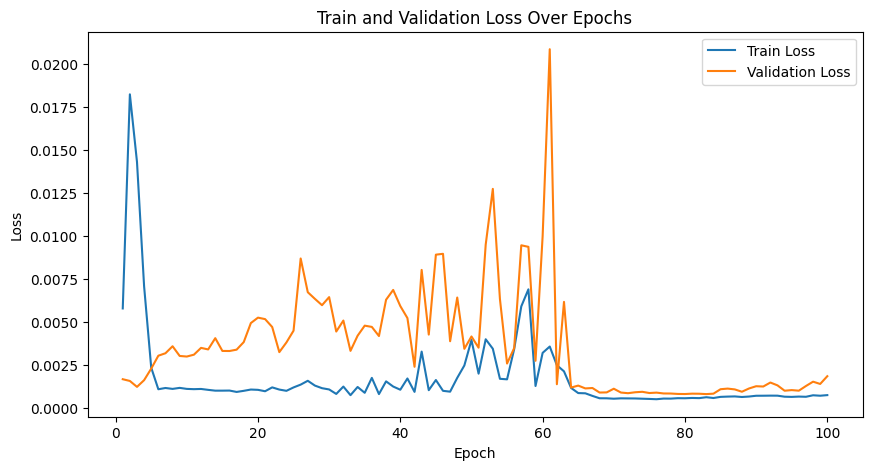

In [7]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [8]:
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][3])
print(close_price_true)


195
[524.0, 521.0, 522.0, 513.0, 516.0, 510.0, 511.0, 505.0, 518.0, 512.0, 517.0, 533.0, 538.0, 539.0, 531.0, 525.0, 530.0, 535.0, 533.0, 530.0, 531.0, 529.0, 524.0, 520.0, 510.0, 516.0, 520.0, 515.0, 510.0, 513.0, 511.0, 507.00003, 498.0, 491.5, 493.5, 502.0, 501.0, 496.00003, 498.0, 500.0, 504.0, 510.0, 503.0, 499.0, 496.00003, 495.50003, 505.0, 519.0, 530.0, 532.0, 531.0, 530.0, 525.0, 543.0, 566.0, 568.0, 566.0, 558.0, 551.0, 562.0, 555.0, 560.0, 568.0, 559.0, 565.0, 574.0, 593.0, 590.0, 591.0, 589.0, 582.99994, 582.99994, 581.0, 574.0, 572.0, 574.0, 573.0, 576.0, 579.0, 584.99994, 582.0, 565.0, 565.0, 565.0, 577.0, 578.0, 584.99994, 591.0, 591.0, 581.0, 581.0, 579.0, 560.0, 558.0, 569.0, 566.0, 569.0, 567.0, 565.0, 567.0, 561.0, 554.0, 558.0, 552.0, 554.0, 551.0, 546.0, 541.0, 542.0, 542.0, 544.0, 539.0, 537.0, 541.0, 552.0, 564.0, 546.0, 549.0, 552.0, 555.0, 549.0, 548.0, 557.0, 552.0, 550.0, 542.0, 539.0, 536.0, 544.0, 541.0, 550.0, 558.0, 540.0, 538.0, 535.0, 527.0, 522.0, 525.

[477.55307, 479.41754, 479.51126, 481.56702, 477.97842, 477.1893, 476.93393, 478.04123, 475.1543, 480.37286, 481.89706, 481.99298, 490.21698, 496.26117, 499.11456, 498.01172, 495.0513, 496.23282, 499.63834, 500.60843, 497.47992, 498.28235, 498.2082, 494.35056, 491.4007, 486.5587, 486.46942, 487.79984, 486.2468, 483.73416, 482.74084, 483.64502, 479.1873, 474.11945, 469.74203, 466.9127, 470.02158, 470.58624, 467.47498, 467.3192, 468.85333, 471.71097, 473.587, 471.6443, 469.71255, 466.4367, 465.18857, 468.968, 475.62875, 486.2238, 490.33252, 490.49042, 490.06836, 488.83704, 496.93414, 512.87933, 519.45337, 518.9719, 515.69196, 511.97894, 516.3055, 516.6087, 516.2089, 520.4418, 520.47046, 521.7043, 527.9787, 539.93243, 542.8244, 543.9692, 544.5484, 542.70984, 541.95636, 542.38776, 540.1602, 538.1318, 540.1145, 541.3155, 540.7508, 543.8192, 548.4732, 550.59393, 543.826, 540.35474, 541.1705, 545.43774, 547.80975, 554.20355, 558.6504, 559.7934, 557.6972, 556.8079, 555.9128, 545.6769, 541.2030

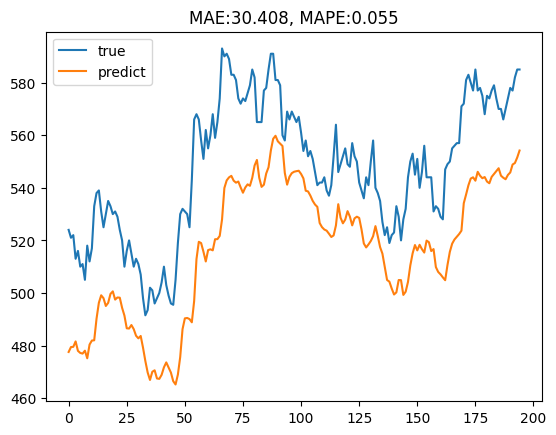

In [9]:
# model = torch.load("model.pt")
# len(test_set)
import matplotlib.pyplot as plt
close_price_pred = []
model = torch.load('gru_10.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][3])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])

In [10]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([195, 10])

In [11]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 3])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)
print(pred_arr)
print(pred_arr[:,9].shape)
print(Y_test[:,9].shape)

torch.Size([195, 10])
tensor([[477.5531, 479.4448, 490.4932,  ..., 513.9543, 510.5781, 510.8095],
        [479.4175, 481.5928, 492.4957,  ..., 515.7665, 512.6580, 512.7969],
        [479.5113, 481.3007, 492.3227,  ..., 516.0957, 513.0228, 513.1080],
        ...,
        [549.4277, 551.7983, 557.0827,  ..., 568.3335, 566.8180, 566.5484],
        [551.5291, 554.0715, 559.1045,  ..., 569.7261, 568.1404, 567.9009],
        [554.1793, 556.4848, 561.1907,  ..., 571.3050, 569.8842, 569.3651]])
torch.Size([195])
torch.Size([195])


In [12]:
mae = torch.mean(torch.abs(pred_arr[:,0] - Y_test[:,0]))
mape = torch.mean(torch.abs(pred_arr[:,0] - Y_test[:,0])/Y_test[:,0])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 30.407907485961914
mape: 0.055499590933322906


In [13]:
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 20.86241340637207
mape: 0.037715595215559006


In [12]:
ma10_f=[]
true=[]
pred=[]
pred_arr = np.array(pred_arr)
Y_test = np.array(Y_test)
for i in range(0,len(pred_arr)):
    true.append(Y_test[i][0])
    ma10_f.append(np.mean(pred_arr[i]))
    pred.append(pred_arr[i][0])
newdf = pd.DataFrame({'True':true, 'Pred':pred, 'MA10_F':ma10_f})
newdf

,True,Pred,MA10_F
0,524.0,499.026123,512.676697
1,521.0,500.439514,514.074036
2,522.0,499.951172,513.919312
3,513.0,501.114532,515.233154
4,516.0,497.882751,512.425903
...,...,...,...
190,578.0,557.620239,567.369751
191,577.0,559.821533,569.293335
192,582.0,560.250183,569.601562
193,585.0,562.905212,571.720032


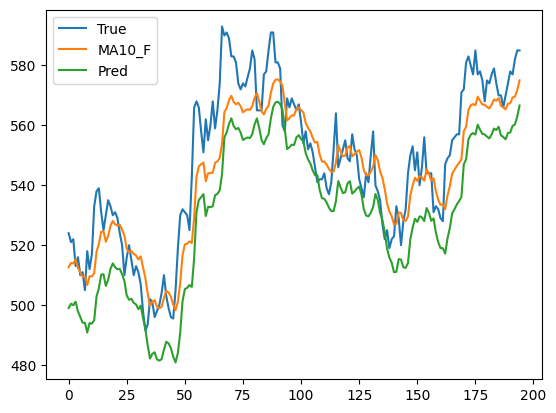

In [13]:
plt.plot(newdf['True'])
plt.plot(newdf['MA10_F'])
plt.plot(newdf['Pred'])
plt.legend(['True','MA10_F','Pred'])

In [14]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, ma10_f, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (ma10_f[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (ma10_f[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['MA10_F'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 495000.0 1
9 1013000.0 -1
10 1013000.0 0
11 1013000.0 0
12 1013000.0 0
13 1013000.0 0
14 1013000.0 0
15 1013000.0 0
16 1013000.0 0
17 1013000.0 0
18 1013000.0 0
19 1013000.0 0
20 1013000.0 0
21 1013000.0 0
22 1013000.0 0
23 489000.0 1
24 489000.0 0
25 489000.0 0
26 489000.0 0
27 1009000.0 -1
28 494000.0 1
29 494000.0 0
30 494000.0 0
31 494000.0 0
32 494000.0 0
33 494000.0 0
34 494000.0 0
35 494000.0 0
36 996000.0 -1
37 495000.0 1
38 495000.0 0
39 495000.0 0
40 995000.0 -1
41 995000.0 0
42 995000.0 0
43 492000.0 1
44 492000.0 0
45 492000.0 0
46 492000.0 0
47 997000.0 -1
48 997000.0 0
49 997000.0 0
50 997000.0 0
51 997000.0 0
52 997000.0 0
53 997000.0 0
54 997000.0 0
55 997000.0 0
56 997000.0 0
57 997000.0 0
58 997000.0 0
59 997000.0 0
60 997000.0 0
61 997000.0 0
62 997000.0 0
63 997000.0 0
64 997000.0 0
65 997000.0 0
66 997000.0 0
67 997000.0 0
68 997000.0 0
69 997000.0 0
70 997000.0 0
71 997000.0 0
72

In [15]:
cash=1000000 #初始資金100w
position=0 #持倉
buy_flag=0
def mothod(true, pred, cash, position, buy_flag):
    income=[]
    buy_flag_arr=[]
    for i in range(1, len(true)):
        if i==0:
            cash=1000000
        elif i==len(true)-1 and position==1:
            cash=cash+position*true[i-1]*1000 #賣
            position=0
            buy_flag=-1
        else:
            if (pred[i]-true[i-1])>=0 and position==0: #預測漲且沒有持倉
                position=1 #買
                entry_price = true[i-1]
                cash=cash-position*entry_price*1000
                buy_flag=1
            elif (pred[i]-true[i-1])<0 and position==1:
                cash=cash+position*true[i-1]*1000 #賣
                position=0
                buy_flag=-1
            else:
                buy_flag=0
        print(i,cash,buy_flag)
        income.append(cash)
        buy_flag_arr.append(buy_flag)
    return income,buy_flag_arr
        # print(position)


money, buy_flag_arr = mothod(newdf['True'], newdf['Pred'], cash, position, buy_flag)

1 1000000 0
2 1000000 0
3 1000000 0
4 1000000 0
5 1000000 0
6 1000000 0
7 1000000 0
8 1000000 0
9 1000000 0
10 1000000 0
11 1000000 0
12 1000000 0
13 1000000 0
14 1000000 0
15 1000000 0
16 1000000 0
17 1000000 0
18 1000000 0
19 1000000 0
20 1000000 0
21 1000000 0
22 1000000 0
23 1000000 0
24 1000000 0
25 1000000 0
26 1000000 0
27 1000000 0
28 1000000 0
29 1000000 0
30 1000000 0
31 1000000 0
32 1000000 0
33 1000000 0
34 1000000 0
35 1000000 0
36 1000000 0
37 1000000 0
38 1000000 0
39 1000000 0
40 1000000 0
41 1000000 0
42 1000000 0
43 1000000 0
44 1000000 0
45 1000000 0
46 1000000 0
47 1000000 0
48 1000000 0
49 1000000 0
50 1000000 0
51 1000000 0
52 1000000 0
53 1000000 0
54 1000000 0
55 1000000 0
56 1000000 0
57 1000000 0
58 1000000 0
59 1000000 0
60 1000000 0
61 1000000 0
62 1000000 0
63 1000000 0
64 1000000 0
65 1000000 0
66 1000000 0
67 1000000 0
68 1000000 0
69 1000000 0
70 1000000 0
71 1000000 0
72 1000000 0
73 1000000 0
74 1000000 0
75 1000000 0
76 1000000 0
77 1000000 0
78 10000

In [12]:
mae = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9]))
mape = torch.mean(torch.abs(pred_arr[:,9] - Y_test[:,9])/Y_test[:,9])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 16.957502365112305
mape: 0.03116261400282383


In [13]:
import csv

with open('ex2output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(pred_arr[:,0])):
    rows[i].append(pred_arr[:,0][i].item())

# 寫回檔案
with open('ex2output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)


